In [1]:
import json
import ast
from datetime import datetime, timezone
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
awkward_uproot_data = json.load(open("/home/jpivarski/storage/data/GitHub-all-user-nonfork-uproot-awkward.json"))

In [3]:
class TrackedObject:
    def __init__(self, name):
        self.name = name
    def __repr__(self):
        return f"TrackedObject({self.name!r})"
    def __str__(self):
        return self.name
    def __hash__(self):
        return hash((TrackedObject, self.name))
    def __eq__(self, other):
        return isinstance(other, TrackedObject) and self.name == other.name
    def __ne__(self, other):
        return not self.__eq__(other)
    def sub(self, name):
        return TrackedObject(f"{self.name}.{name}")
    def call(self, args):
        return TrackedCall(self, args)

class TrackedCall:
    def __init__(self, function, args, has_star, source):
        self.function = function
        self.args = args
        self.has_star = has_star
        self.source = source
    def __repr__(self):
        return f"TrackedCall({self.function!r}, {self.args!r}, {self.has_star!r}, {self.source!r})"
    def __str__(self):
        args = []
        for i, (n, v) in enumerate(self.args):
            if str(i) == n:
                k = ""
            else:
                k = f"{n}="
            if v is None:
                args.append(f"{k}?")
            else:
                args.append(f"{k}{json.loads(v)!r}")
        return f"{self.function!s}({', '.join(args)}{', *whatever' if self.has_star else ''})"
    def __hash__(self):
        return hash((TrackedCall, self.function, self.args, self.has_star, self.source))
    def __eq__(self, other):
        return isinstance(other, TrackedCall) and self.function == other.function and self.args == other.args and self.has_star == other.has_star and self.source == other.source

def from_attribute(tree, scope):
    if isinstance(tree, ast.Name) and tree.id in scope:
        if isinstance(scope[tree.id], TrackedObject):
            return scope[tree.id]
    elif isinstance(tree, ast.Attribute):
        obj = from_attribute(tree.value, scope)
        if isinstance(obj, TrackedObject):
            return obj.sub(tree.attr)

def literal(tree):
    try:
        return json.dumps(ast.literal_eval(tree))
    except (ValueError, TypeError, SyntaxError, MemoryError, RecursionError):
        return None

def tracked(tree):
    out = []

    def analyze(tree, scope):
        if isinstance(tree, ast.Import):
            analyze(tree.names, scope)
            for alias in tree.names:
                if alias.name.split(".")[0] in ("uproot", "uproot3", "uproot4"):
                    obj = TrackedObject(".".join(["uproot"] + alias.name.split(".")[1:]))
                    out.append(obj)
                    scope[alias.name if alias.asname is None else alias.asname] = obj
                if alias.name.split(".")[0] in ("awkward", "awkward0", "awkward1"):
                    obj = TrackedObject(".".join(["ak"] + alias.name.split(".")[1:]))
                    out.append(obj)
                    scope[alias.name if alias.asname is None else alias.asname] = obj
        elif isinstance(tree, ast.ImportFrom):
            analyze(tree.module, scope)
            analyze(tree.names, scope)
            analyze(tree.level, scope)
            if tree.module is not None and tree.module.split(".")[0] in ("uproot", "uproot3", "uproot4", "awkward", "awkward0", "awkward1"):
                base = TrackedObject(tree.module)
                for alias in tree.names:
                    obj = base.sub(alias.name)
                    out.append(obj)
                    scope[alias.name if alias.asname is None else alias.asname] = obj
        elif isinstance(tree, ast.Attribute):
            analyze(tree.value, scope)
            analyze(tree.attr, scope)
            analyze(tree.ctx, scope)
            if isinstance(tree.ctx, ast.Load):
                obj = from_attribute(tree, scope)
                if isinstance(obj, TrackedObject):
                    out.append(obj)
        elif isinstance(tree, ast.Call):
            analyze(tree.func, scope)
            analyze(tree.args, scope)
            analyze(tree.keywords, scope)
            obj = from_attribute(tree.func, scope)
            if isinstance(obj, TrackedObject):
                args = []
                for i, x in enumerate(tree.args):
                    if not isinstance(x, ast.Starred):
                        args.append((str(i), literal(x)))
                for x in sorted([x for x in tree.keywords if x.arg is not None], key=lambda x: x.arg):
                    args.append((x.arg, literal(x.value)))
                has_star = any(isinstance(x, ast.Starred) for x in tree.args) or any(x.arg is None for x in tree.keywords)
                out.append(TrackedCall(obj, tuple(args), has_star, ast.unparse(tree)))
        elif isinstance(tree, (ast.Assign, ast.AnnAssign)):
            if isinstance(tree, ast.Assign):
                analyze(tree.targets, scope)
                analyze(tree.value, scope)
                analyze(tree.type_comment, scope)
                targets = tree.targets
            elif isinstance(tree, ast.AnnAssign):
                analyze(tree.target, scope)
                analyze(tree.annotation, scope)
                analyze(tree.value, scope)
                analyze(tree.simple, scope)
                targets = [tree.target]
            for target in targets:
                if isinstance(target, ast.Name):
                    obj = from_attribute(tree.value, scope)
                    if isinstance(obj, TrackedObject):
                        scope[target.id] = obj
                    else:
                        scope[target.id] = literal(tree.value)
                elif isinstance(target, ast.Tuple) and isinstance(tree.value, ast.Tuple) and len(target.elts) == len(tree.value.elts):
                    for t, v in zip(target.elts, tree.value.elts):
                        if isinstance(t, ast.Name):
                            obj = from_attribute(v, scope)
                            if isinstance(obj, TrackedObject):
                                scope[t.id] = obj
                            else:
                                scope[t.id] = literal(v)
        elif isinstance(tree, ast.AugAssign):
            analyze(tree.target, scope)
            analyze(tree.op, scope)
            analyze(tree.value, scope)
            if isinstance(tree.target, ast.Name) and tree.target.id in scope:
                del scope[tree.target.id]
        elif isinstance(tree, ast.Delete):
            analyze(tree.targets, scope)
            for target in tree.targets:
                if isinstance(target, ast.Name) and target.id in scope:
                    del scope[target.id]
        elif isinstance(tree, ast.FunctionDef):
            analyze(tree.name, scope)
            analyze(tree.args, scope)
            analyze(tree.body, dict(scope))
            analyze(tree.decorator_list, scope)
            analyze(tree.returns, scope)
        elif isinstance(tree, ast.Lambda):
            analyze(tree.args, scope)
            analyze(tree.body, dict(scope))
        elif isinstance(tree, ast.AST):
            for fieldname in tree._fields:
                analyze(getattr(tree, fieldname), scope)
        elif isinstance(tree, list):
            for x in tree:
                analyze(x, scope)
        elif isinstance(tree, (bool, int, float, complex, str, bytes)):
            pass
        elif tree is None or tree is Ellipsis:
            pass
        else:
            raise NotImplementedError(f"{type(tree) = } {repr(tree) = }")
    
    analyze(tree, {})
    
    return out

In [4]:
for repodata in awkward_uproot_data:
    for filedata in repodata["files"]:
        if filedata["name"].startswith("nickh2000/EMTF-DQM-Website/csctimingenv/"):
            filedata["ast"] = None
            filedata["tracked"] = []
            continue   # avoid two vendored copies of Uproot's own codebase
        try:
            syntax_tree = ast.parse(filedata["text"])
        except SyntaxError:
            filedata["ast"] = None
            filedata["tracked"] = []
        else:
            filedata["ast"] = syntax_tree
            filedata["tracked"] = tracked(syntax_tree)

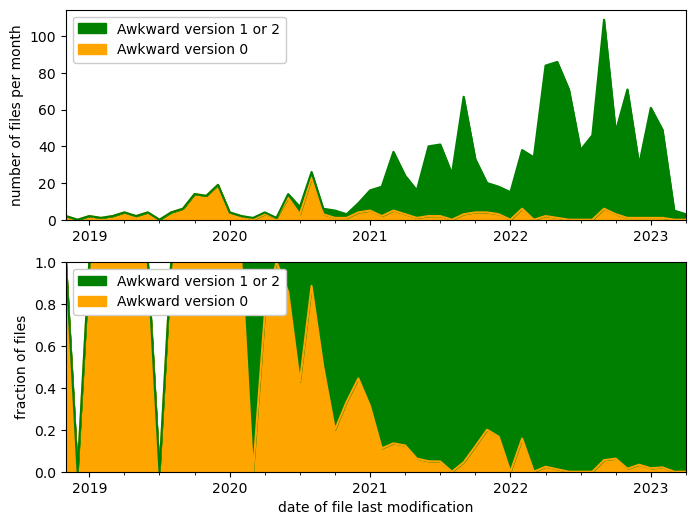

In [5]:
def is_awkward0(obj):
    return obj.function.name.startswith(
        "ak.JaggedArray"
    ) or obj.function.name in (
            "ak.IndexedArray",
            "ak.Table",
            "ak.array.jagged.JaggedArray.concatenate",
            "ak.fromarrow",
            "ak.fromiter",
            "ak.hdf5",
            "ak.load",
            "ak.save",
            "ak.toarrow",
            "ak.topandas",
            "ak.util.concatenate",
        )

file_dates = []
file_isak0 = []

for repodata in awkward_uproot_data:
    for filedata in repodata["files"]:
        is_awkward = False
        is_0 = False
        for obj in filedata["tracked"]:
            if isinstance(obj, TrackedCall) and obj.function.name.startswith("ak."):
                is_awkward = True
                is_0 = is_0 or is_awkward0(obj)
        if is_awkward:
            file_dates.append(datetime.fromtimestamp(filedata["date"]).astimezone(timezone.utc))
            file_isak0.append(is_0)
            if file_dates[-1] < datetime(2020, 1, 1, tzinfo=timezone.utc):
                assert is_0, filedata["name"]

df = pd.DataFrame({"Awkward version 0": file_isak0}, index=file_dates)
df["Awkward version 1 or 2"] = ~df["Awkward version 0"]
df["Total"] = True

df2 = df.resample("M", origin=pd.to_datetime("2013-01-01")).sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

df2[["Awkward version 0", "Awkward version 1 or 2"]].plot.area(ax=ax1, color=["orange", "green"]);

handles, labels = ax1.get_legend_handles_labels();
ax1.legend(handles[::-1], labels[::-1], loc="upper left", facecolor="white", framealpha=1);
ax1.set_ylabel("number of files per month");

df2.div(df2["Total"], axis=0)[["Awkward version 0", "Awkward version 1 or 2"]].plot.area(ax=ax2, color=["orange", "green"]);

handles, labels = ax2.get_legend_handles_labels();
ax2.legend(handles[::-1], labels[::-1], loc="upper left", facecolor="white", framealpha=1);
ax2.set_ylim(0, 1);
ax2.set_ylabel("fraction of files");
ax2.set_xlabel("date of file last modification");

fig.savefig("github-ast-awkward-0-1.svg");
fig.savefig("github-ast-awkward-0-1.pdf");

In [33]:
def simplify_type(v):
    if v is None:
        return None

    data = json.loads(v)
    if isinstance(data, int):
        return v
    elif isinstance(data, float):
        return '"float"'
    elif data in ("np", "ak", "pd"):
        return v
    elif isinstance(data, (str, bytes)):
        return '"str"'
    elif data is None:
        return "null"
    elif data is False:
        return "false"
    elif data is True:
        return "true"
    elif isinstance(data, list) and all(isinstance(x, str) for x in data):
        return '["strings"]'
    else:
        return v

def simplify(obj):
    return TrackedCall(obj.function, tuple((n, simplify_type(v)) for n, v in obj.args), obj.has_star, "null")

awkward_functions = Counter()
uproot_functions = Counter()

for repodata in awkward_uproot_data:
    for filedata in repodata["files"]:
        for obj in filedata["tracked"]:
            if isinstance(obj, TrackedCall) and obj.function.name.startswith("ak.") and not is_awkward0(obj):
                awkward_functions[simplify(obj)] += 1
            elif isinstance(obj, TrackedCall) and obj.function.name.startswith("uproot."):
                uproot_functions[simplify(obj)] += 1

In [34]:
for obj, count in sorted(awkward_functions.items(), key=lambda x: -x[1])[:50]:
    print(f"{count:4d} {obj!s}")

2832 ak.flatten(?)
2498 ak.num(?)
2193 ak.to_numpy(?)
 874 ak.sum(?, axis=1)
 865 ak.flatten(?, axis=None)
 564 ak.sum(?)
 455 ak.ones_like(?)
 406 ak.Array(?)
 283 ak.concatenate(?)
 265 ak.singletons(?)
 248 ak.num(?, axis=1)
 246 ak.concatenate(?, axis=1)
 235 ak.any(?, axis=1)
 234 ak.zip(?, with_name='str')
 233 ak.to_pandas(?)
 226 ak.unzip(?)
 221 ak.firsts(?)
 220 ak.zip(?)
 215 ak.flatten(?, axis=1)
 214 ak.prod(?, axis=1)
 209 ak.unflatten(?, ?)
 202 ak.fill_none(?, 0)
 198 ak.where(?, ?, ?)
 191 ak.from_parquet(?)
 191 ak.argmax(?, axis=1)
 182 ak.values_astype(?, ?)
 169 ak.to_parquet(?, ?)
 164 ak.cartesian(?, nested=True)
 161 ak.to_list(?)
 156 ak.behavior.update(?)
 147 ak.to_awkward0(?)
 141 ak.argsort(?, ascending=False)
 119 ak.zeros_like(?)
 112 ak.sum(?, axis=-1)
 103 ak.any(?)
 103 ak.where(?)
 102 ak.pad_none(?, 1)
 100 ak.argsort(?, ascending=False, axis=1)
  97 ak.mask(?, ?)
  95 ak.where(?, ?, -1)
  92 ak.broadcast_arrays(?, ?)
  91 ak.all(?, axis=1)
  88 ak.m

In [35]:
for obj, count in sorted(uproot_functions.items(), key=lambda x: -x[1])[:50]:
    print(f"{count:4d} {obj!s}")

2150 uproot.open(?)
 889 uproot.open('str')
 198 uproot.recreate(?)
 179 uproot.tree.TBranchMethods.array(?)
  74 uproot.lazy(?)
  58 uproot.newtree(?)
  57 uproot.pandas.iterate(?, 'str', ['strings'])
  44 uproot.open(?, xrootdsource=?)
  23 uproot.lazy(?, filter_name=?)
  22 uproot.recreate('str')
  18 uproot.create(?)
  15 uproot.recreate(?, compression=?)
  13 uproot.newbranch(?, size='str')
  11 uproot.numentries(?, ?)
  11 uproot.ArrayCache('str')
  10 uproot.numentries(?, ?, total=False)
  10 uproot.numentries(?, ?, executor=?, total=False)
   9 uproot.recreate('str', compression=None)
   9 uproot.open(?, *whatever)
   8 uproot.iterate(?, 'str', ?, entrysteps=?, executor=?)
   8 uproot.open('str', xrootdsource=?)
   8 uproot.open(?, timeout=None, xrootd_handler=?)
   7 uproot.open(?, timeout=?)
   7 uproot.ZLIB(4)
   7 uproot.newbranch(?, size=?)
   6 uproot.open(path=?)
   6 uproot.FileSource(?, *whatever)
   6 uproot.newtree({'mass': 'float64'})
   6 uproot.cache.ThreadSafeArr